In [1]:
"Portfolio notebook"

'Portfolio notebook'

This notebook analyzes the impact of climate scenarios on credit risk for firms and portfolios. It includes:

- Modeling firm-level emissions and production under different SSP scenarios.
- Calculating default probabilities and portfolio losses.
- Exploring PCA and Polynomial Chaos Expansion (PCE) approximations for portfolio loss.
- Assessing the impact of physical risks on portfolio losses.

The analysis is based on the methodology described in this [paper](https://hal.science/hal-04665712/document).


# Imports


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import integrate, interpolate, optimize, sparse
from tqdm import tqdm

import utils
from firm import Firm
from utils import COLORS_SSP, SCENARIOS, set_plot_style

SEED = 1234  # for reproductibility
set_plot_style()
%config InlineBackend.figure_format = 'retina'

In [4]:
# Set maturities: t=0 corresponds to the year 2015
T_SSP_INITIAL = 2015.0
T_SSP_FINAL = 2100.0
T_FINAL = T_SSP_FINAL - T_SSP_INITIAL

# Model


For each obligor $i \in {1,\ldots,n}$, we model the log production $p_t^i$ as

$$ dp_t^i = \left(a^i -b^i p_t^i + \sum_{e} c_e^i \times \gamma_{e,t}^i \times \theta_{e,t}^i\right) + \sigma^i dW_t^i $$

where

$$ dW_t^i = \rho^i \, dB_t + \sqrt{1 - (\rho^i)^2} \, dB_t^i $$

with correlations $\rho^i \in (-1,1)$ and $B, B^1,\dots,B^n$ are $n+1$ standard Browian motions.

$B$ reads as a systemic risk factor and the $(B^{i})_{1\leq i\leq n}$ as independent idiosyncratic risk factors. The sum $\sum_{e}$ runs through all energy types.

The portfolio loss is given by

$$ \mathcal{L}_t = \frac{1}{n} \sum_{i=1}^{n} \Lambda^i \mathbf{1}_{\widehat{V}_{t}^{i} \leq L^i(t)} $$

where $\widehat{V}_{t}^{i} = h^i (t, \widehat{p}_{t}^{i})$ with $h^i(\cdot,\cdot)$ some deterministic function and $\Lambda^i$ is the exposure at default (EAD) times the loss given default (LGD).

Conditionally on $\mathcal{F}_{t}$, the optimal log production $\big(\widehat{p}_{u}^{i}\big)_{1\leq i\leq n}$ is an $n$-dimensional Gaussian vector with conditional mean

$$ \mathbb{E}\big[\widehat{p}_{u}^{i} | \mathcal{F}_{t}\big] = e^{-b^i(u-t)} \widehat{p}_{t}^{i} + m^{i}(u,t), $$

where

$$ m^i \big( t, u \big) = \frac{a^i}{b^i} (1 - e^{-b^i (u - t)}) + \int_t^u e^{-b^i (u - s)} \sum_{e} c^i_e \, \theta^i_{e,s} \, \widehat{\gamma}^i_{e, s} \, ds $$

and conditional covariance

$$ \mathrm{Cov}\big(\widehat{p}_{u}^{i} \, \widehat{p}_{u}^{j} | \mathcal{F}_t\big) = \sigma^{i}\sigma^{j} \left(\rho^{i}\rho^{j}{\bf 1}_{i\neq j}+{\bf 1}_{i=j}\right) \frac{1-e^{-(b^i+b^j)(u-t)}}{b^i+b^j}, $$

for every $i,j \in {1,\ldots,n}$.

We can rewrite the default event as

$$ { \widehat{V}_{t}^{i} \leq L^i(t) } = { h^{i} (t, \widehat{p}^i_t) \leq L^i(t) } = { A_t^i = X_t^i } $$

where

$$ A_t^i = \frac{1}{\sigma^i} \left[ e^{-b^i t} \, \widehat{p}_0^{i} + m^{i}(t,0) + \sigma^i\sqrt{1-(\rho^i)^{2}}\int_{0}^{t}e^{-b^i(t-s)} \, dB_{s}^{i} - (h^{i} (t,\cdot))^{-1} (L^{i}(t)) \right] $$

and

$$ X_t^i = -\rho^i \int_{0}^{t} e^{-b^i(t-s)} \, dB_{s} $$


# Portfolio of obligors


We now consider a portfolio of obligors, each with its own set of parameters.

To speed up the simulation, we use 100 firms. The larger the number of firms, 
the better the approximation.

In [5]:
np.random.seed(SEED)

# N_FIRMS = 1_000  # number of firms
N_FIRMS = 100  # number of firms
LAMBDA_REF = 0.03  # reference default intensity
T = 5.0  # portfolio loss matury
PROD_0 = 1.0  # intial production
INT_RATE = 0.02  # interest rate

# Generate random firm parameters
tab_sig = np.random.uniform(low=0.0, high=0.5, size=N_FIRMS)
mat_sig = np.tile(tab_sig, (N_FIRMS, 1))
tab_a = np.random.uniform(low=0.0, high=0.5, size=N_FIRMS)
tab_b = np.random.uniform(low=1.0, high=4.0, size=N_FIRMS)
mat_b = np.tile(tab_b, (N_FIRMS, 1))
tab_rho = np.random.uniform(-1, 1, N_FIRMS)
mat_rho = np.tile(tab_rho, (N_FIRMS, 1))

In [6]:
# Common parameters for each obligor
params = {
    "prod_0": PROD_0,
    "r": INT_RATE,
    "c": np.array([0.01, 0.01, 0.01]),
    "n_units": 1.0,
    "w_1": 0.05,
    "w_2": 0.02,
    "alpha": np.array([0.0, 0.0, 0.0]),
    "beta": np.array([0.1, 0.5, 0.8]),
    "theta": np.array([1.0, 1.0, 1.0]),
    "t_final": T_FINAL,
    "sector": "Transportation Sector",
}

In [7]:
# Compute Cholesky decomposition of the vector of log productions (p^i)
mat_rho_one_diag = mat_rho.copy()
mat_rho_one_diag[np.arange(N_FIRMS), np.arange(N_FIRMS)] = 1.0
cov_mat_p = (
    mat_sig
    * mat_sig.T
    * mat_rho_one_diag
    * mat_rho_one_diag.T
    * (1.0 - np.exp(-(mat_b + mat_b.T) * T))
    / (mat_b + mat_b.T)
)
L_chol_p = np.linalg.cholesky(cov_mat_p)

# Check that Cholesky decomposition worked
assert np.allclose(L_chol_p @ L_chol_p.T, cov_mat_p)

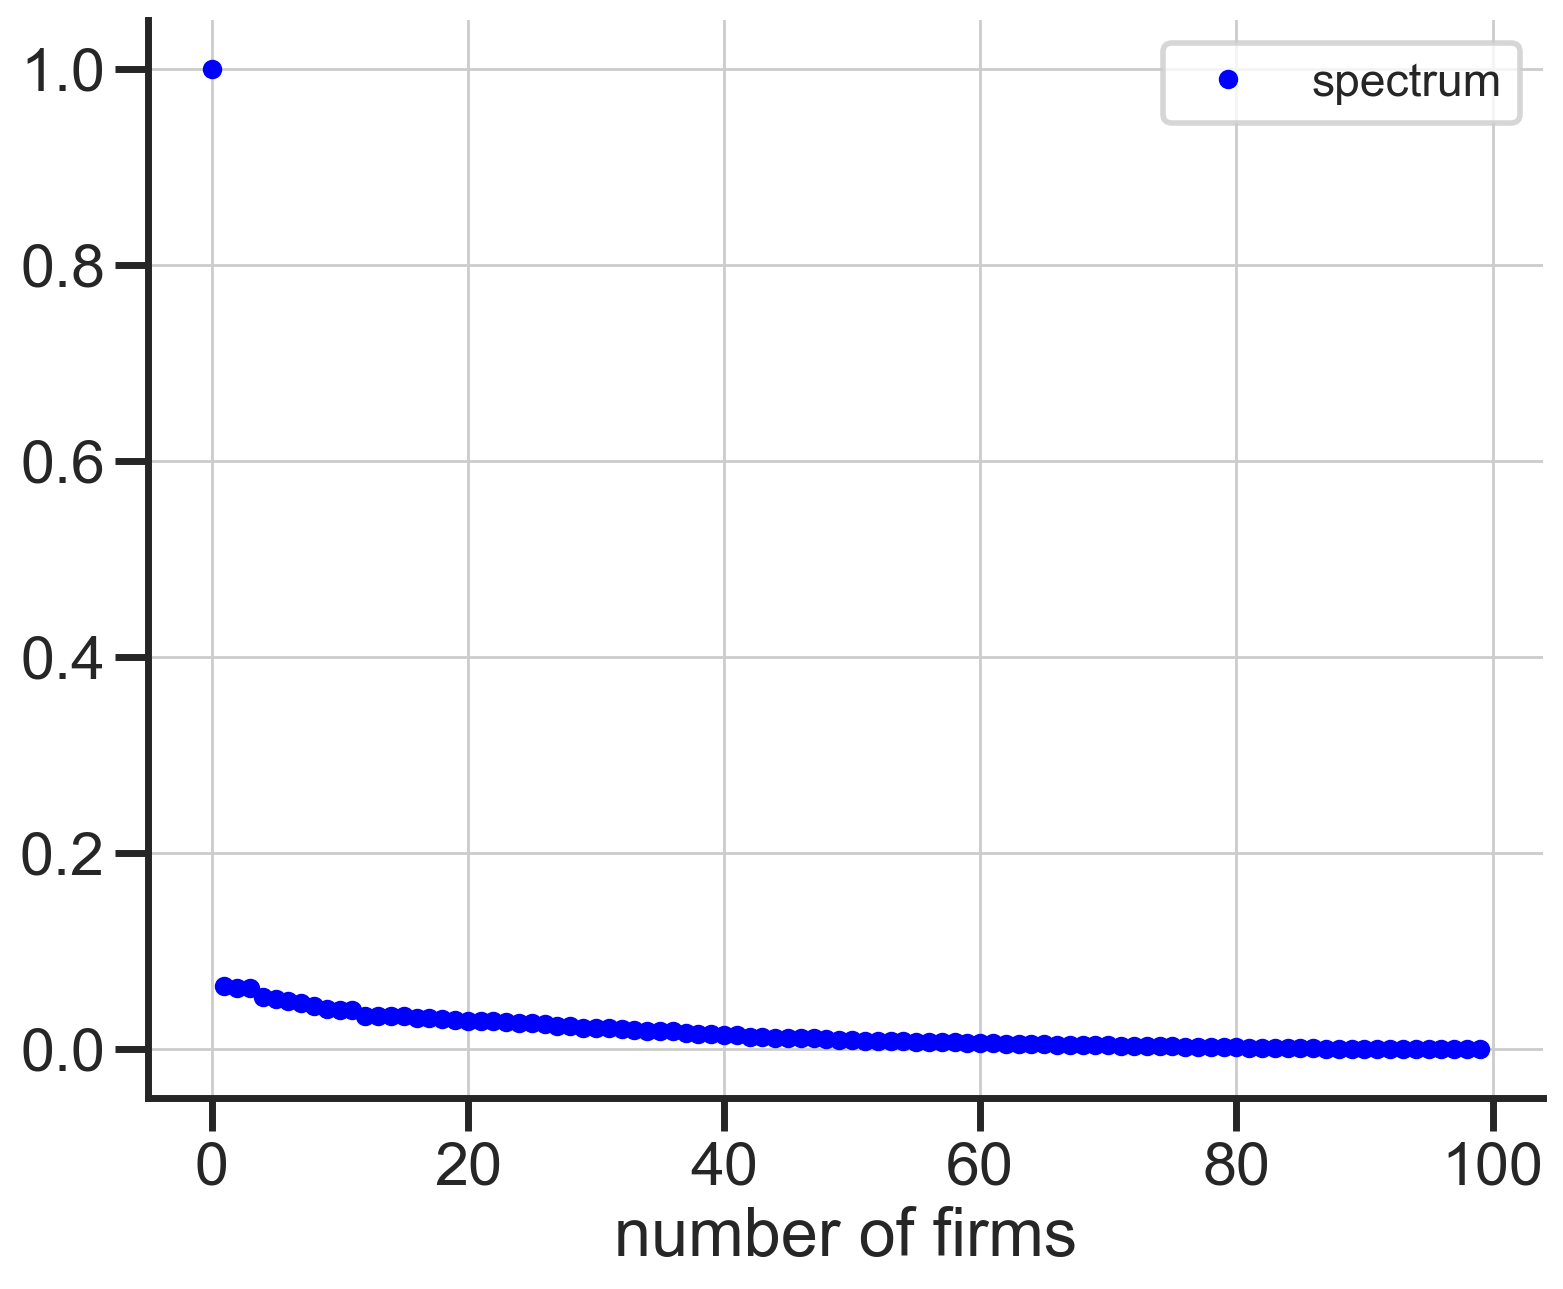

In [8]:
# Plot the covariance matrix spectrum
# If the portfolio is (very) correlated, the spectrum decreases fast.

_, eigs_cov, _ = np.linalg.svd(cov_mat_p)

fig, ax = plt.subplots()
ax.plot(eigs_cov / eigs_cov[0], ".b", label="spectrum")
ax.set_xlabel("number of firms")
ax.legend()
plt.show()

# Cumulative loss of the portfolio


In [9]:
# Select a subset of SCENARIOS

# sub_scenarios = ("SSP1-26", "SSP3-70 (Baseline)", "SSP5-85 (Baseline)")
sub_scenarios = ("SSP1-26",)

In [10]:
# For each scenario, we store the mean, default boundary, inverse h
# and the firm instances. This takes some time.

mean_dict = {}
default_boundary_dict = {}
h_inv_L_dict = {}
firms_dict = {}

# Default parameters for the unpenalized firm
params_no_pen = params.copy()
params_no_pen["w_1"] = 0.0
params_no_pen["w_2"] = 0.0

for scenario in sub_scenarios:
    print(scenario)

    list_firms = []
    tab_mean_T = np.zeros(N_FIRMS)
    tab_L_T = np.zeros(N_FIRMS)
    tab_h_T_inv_L_T = np.zeros(N_FIRMS)

    for i in tqdm(range(N_FIRMS)):
        # Update parameters for the current firm
        for key, value in zip(
            ["sig", "a", "b"],
            [tab_sig[i], tab_a[i], tab_b[i]],
        ):
            params[key] = value
            params_no_pen[key] = value

        firm = Firm(**params, scenario=scenario)
        L_T_i = Firm.default_boundary_unpenalized(
            t=T,
            lbd_ref=LAMBDA_REF,
            firm_no_pen=Firm(**params_no_pen, scenario=scenario),
        )[0]

        result = optimize.minimize_scalar(
            lambda x, firm=firm, y=L_T_i: 0.5 * (firm.h(t=T, x=x) - y) ** 2
        )
        if result.success:
            tab_h_T_inv_L_T[i] = result.x[0]
        else:
            raise RuntimeError(
                f"Optimization failed for firm {i} in scenario {scenario}",
            )

        list_firms.append(firm)
        tab_mean_T[i] = firm.mean_production(u=T, t=0.0)
        tab_L_T[i] = L_T_i

    mean_dict[scenario] = tab_mean_T
    default_boundary_dict[scenario] = tab_L_T
    firms_dict[scenario] = list_firms
    h_inv_L_dict[scenario] = tab_h_T_inv_L_T

SSP1-26


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Different functions for $\Lambda^i$ (LGD times EAD). For example, $\Lambda^i=\frac{1}{\sqrt{i}}$ or $\Lambda^i=\lceil(5i/n)\rceil^2$


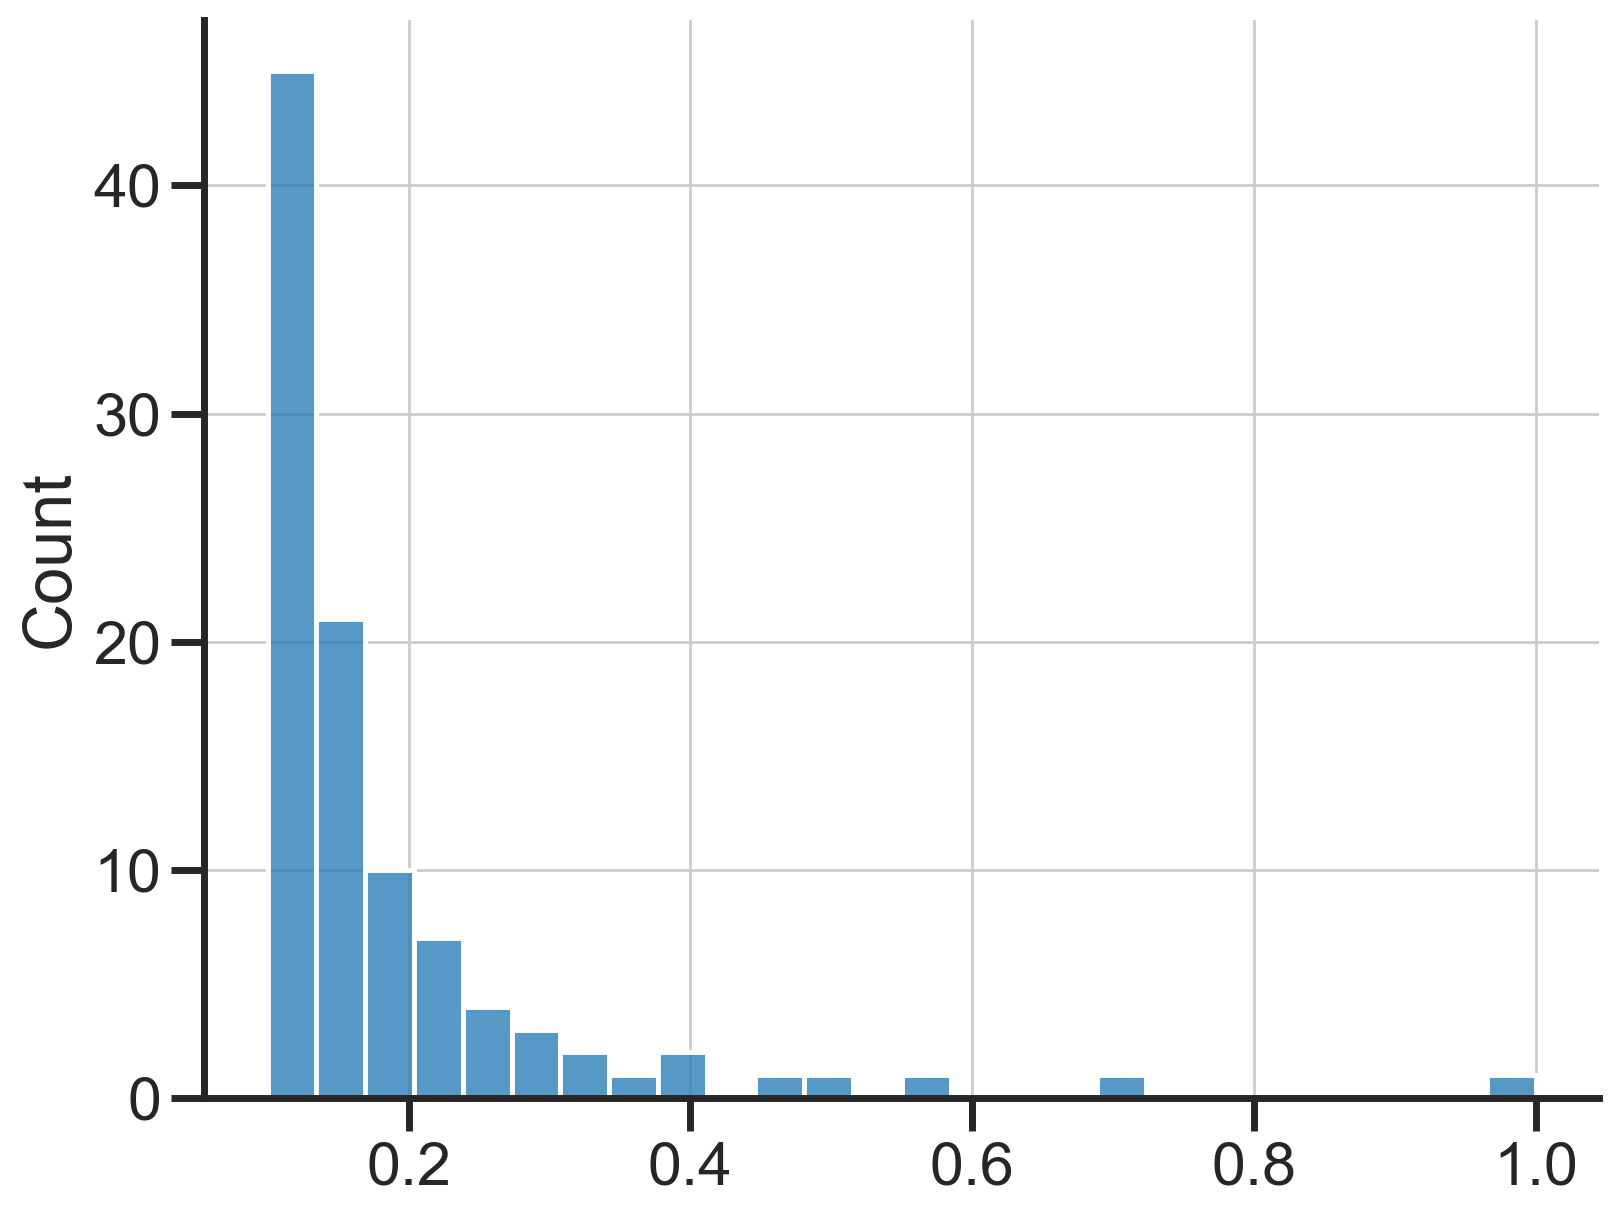

In [11]:
# Precompute vector of Lambda^i
tab_lambda = utils.lambda_lgd_ead(
    idx=np.arange(1, N_FIRMS + 1),
    n_firms=N_FIRMS,
)

# Plot histogram
sns.histplot(tab_lambda);

In [12]:
# Number of Monte Carlo samples
N_MC = 100_000

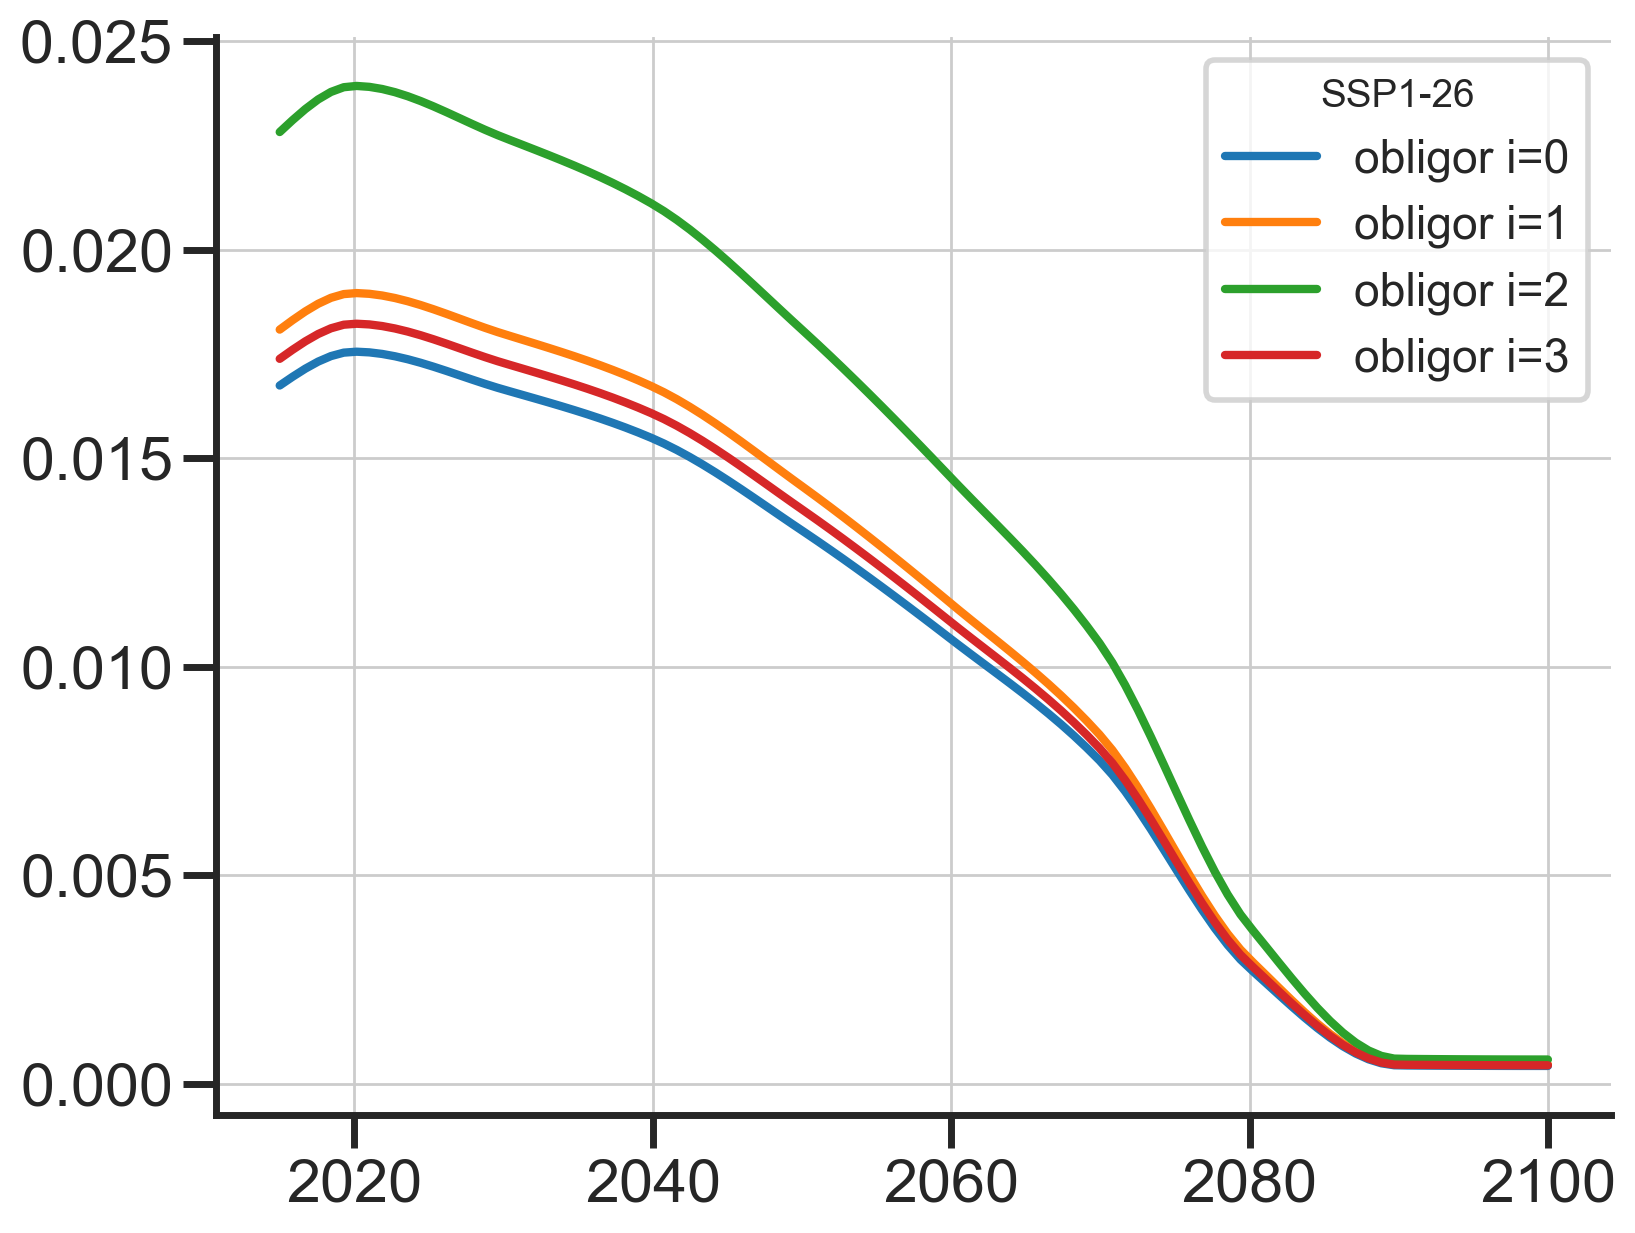

In [13]:
# Plot some renormalized SSP scenarios for different obligors
tab_t = np.linspace(0.0, T_FINAL, 100)
fig, ax = plt.subplots()
for name in sub_scenarios[:1]:
    for i in range(4):
        _firm = firms_dict[name][i]
        ax.plot(
            T_SSP_INITIAL + tab_t,
            _firm.f_scenario(tab_t),
            "-",
            label=f"obligor i={i}",
        )
ax.legend(title=name)
plt.show()

In [14]:
# Compute Cholesky decomposition of the covariance matrix of the vector X
cov_X = (
    (-mat_rho)
    * (-mat_rho.T)
    * (1.0 - np.exp(-(mat_b + mat_b.T) * T))
    / (mat_b + mat_b.T)
)

try:
    L_chol_X = np.linalg.cholesky(cov_X)
    print("Cholesky")
except np.linalg.LinAlgError:
    L_chol_X = utils.cholesky_from_svd(cov_X)
    print("Cholesky from SVD")

assert np.allclose(L_chol_X @ L_chol_X.T, cov_X)

Cholesky from SVD


In [15]:
# Check SVD - this might take time if n_firms is large
U, S, U_transpose = np.linalg.svd(cov_X)
S_diag = np.diag(S)

# Check SVD decomposition
assert np.allclose(U @ S_diag @ U_transpose, cov_X)

# PCA


In [16]:
# Check PCA or Spectral Decomposition. We recover the covariance matrix cov_X.
cov_X_pca = np.zeros_like(cov_X)

for i in range(N_FIRMS):
    U_i = U[:, i].reshape(-1, 1)
    cov_X_pca += S[i] * U_i @ U_i.T

assert np.allclose(cov_X_pca, cov_X)

As $X_t \sim \mathcal{N}(0,K_{X_t})$, and $K_{X_t} = \sum_{k=1}^{n} \nu^k u^{k} (u^{k})^{\top}$, we can write

$$ X_t = \sum_{i=1}^{n} \sqrt{\nu^k} G^k u^k $$

where $K_X = U \, \textrm{diag}(\nu^1,\ldots,\nu^n) \, U^T$ and $U = [u^1, \dots, u^n]$.

We will use a two-factor approximation

$$ X_t \approx \sqrt{\nu^1} G^1 u^1 + \sqrt{\nu^2} G^2 u^2 $$

and the PCA approximation for the portfolio loss is given as

$$ \mathcal{L}_{t} \approx \mathcal{L}^{\textrm{PCA}}_{t} := \sum_{i=1}^{n} \Lambda^{i} \, \mathbf{1}_{ { A_{t}^{i} \leq \sqrt{\nu^{1}} G^{1} u^{1, i} + \sqrt{\nu^{2}} G^{2} u^{2, i} } } $$


In [17]:
# Number of factors for the PCA approximation.
N_FACTORS = 2

In [18]:
# Instead of doing a full SVD, it is enough to get the largest
# eigenvalues and associated eigenvectors.
_eigs_cov_X, _U_cov_X = sparse.linalg.eigs(cov_X, k=N_FACTORS)  # type: ignore
eigs_cov_X = np.real(_eigs_cov_X)
U_cov_X = np.real(_U_cov_X)

In [19]:
# Pre-compute parameters of vector A.
mean_a = {}
std_a = {}

for name in sub_scenarios:
    std_a[name] = np.sqrt(1.0 - tab_rho**2) * np.sqrt(
        (1.0 - np.exp(-2.0 * tab_b * T)) / (2.0 * tab_b)
    )
    mean = np.exp(-tab_b * T) * np.log(PROD_0)
    mean += mean_dict[name] - h_inv_L_dict[name]
    mean_a[name] = mean / tab_sig

Sample loss $\mathcal{L}_t$ using vector of log productions $(\widehat{p}_t^i)_{i=1,\ldots,n}$.

We use the representation

$$ \mathcal{L}_t = \frac{1}{n} \sum_{i=1}^{n} \Lambda^i \mathbf{1}_{\widehat{p}_{t}^{i} \leq (h^i(t,\cdot))^{-1}(L^i(t))} $$


In [20]:
np.random.seed(SEED)
loss_dict = {}
for name in sub_scenarios:
    # simulation of log production at maturity p_T
    z = np.random.randn(N_FIRMS, N_MC)
    p_T = (np.exp(-tab_b * T) * np.log(PROD_0) + mean_dict[name])[
        :, None
    ] + L_chol_p @ z

    # summing over all firms to get loss
    loss_dict[name] = np.sum(
        tab_lambda[:, None] * 1.0 * (p_T <= h_inv_L_dict[name][:, None]),
        axis=0,
    )

Sample $\mathcal{L}_{t}^{\textrm{PCA}}$ using vectors $A_t$ and $X_t$. Recall that

$$ \mathcal{L}^{\textrm{PCA}}_{t} := \sum_{i=1}^{n} \Lambda^{i} \, \mathbf{1}_{ { A_{t}^{i} \leq \sqrt{ \nu^{1}} G^{1} u^{1, i} + \sqrt{\nu^{2}} G^{2} u^{2, i} } }. $$


In [21]:
np.random.seed(SEED)
loss_pca = {}
for name in sub_scenarios:
    g_ind = np.random.randn(N_FIRMS, N_MC)
    vec_a = mean_a[name][:, None] + std_a[name][:, None] * g_ind

    # PCA approximation
    vec_x_pca = np.zeros_like(vec_a)
    for k in tqdm(range(N_FACTORS)):
        g_k = np.random.randn(N_MC)
        U_g_k = U_cov_X[:, k][:, None] * g_k[None, :]
        vec_x_pca += np.sqrt(eigs_cov_X[k]) * U_g_k

    # Summing over all firms to get loss
    ind_a = 1.0 * (vec_a <= vec_x_pca)
    loss_pca[name] = np.sum(tab_lambda[:, None] * ind_a, axis=0)

100%|██████████| 2/2 [00:00<00:00, 18.76it/s]


In [22]:
# Sanity check with full PCA
np.random.seed(SEED)
loss_dict_check = {}
for name in sub_scenarios:
    print(name)

    g_ind = np.random.randn(N_FIRMS, N_MC)
    vec_a = mean_a[name][:, None] + std_a[name][:, None] * g_ind

    g = np.random.randn(N_FIRMS, N_MC)
    vec_X = L_chol_X @ g
    ind_a = 1.0 * (vec_a <= vec_X)
    loss_dict_check[name] = np.sum(tab_lambda[:, None] * ind_a, axis=0)

SSP1-26


Plot of portfolio losses $\mathcal{L}$ for different scenarios


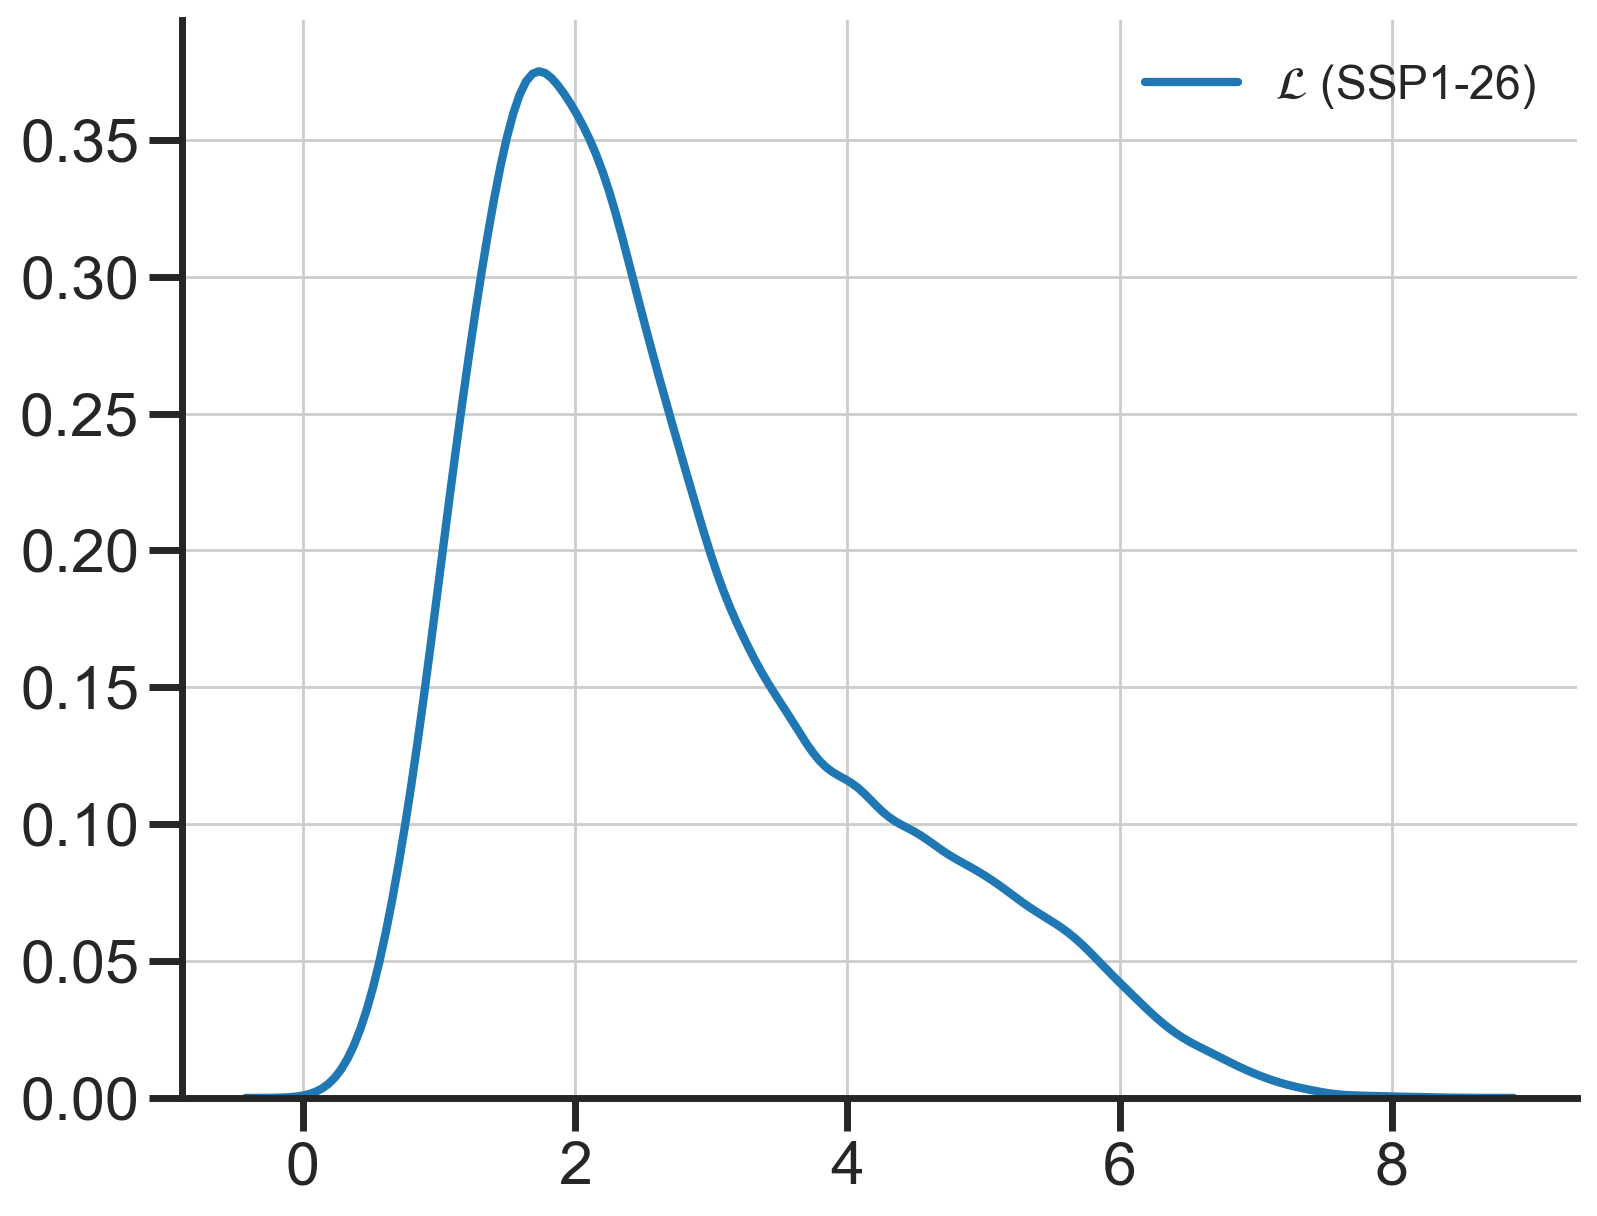

In [23]:
fig, ax = plt.subplots()
for name in sub_scenarios:
    sns.kdeplot(
        data=loss_dict[name],
        linestyle="-",
        label=f"$\\mathcal{{L}}$ ({name})",
        ax=ax,
    )
    # # sanity check
    # sns.kdeplot(
    #     data=loss_dict_check[name],
    #     linestyle="--",
    #     label=f"$\\mathcal{{L}}$ ({name}) full PCA",
    #     ax=ax,
    # )
ax.legend(framealpha=0.0, loc="best")
ax.set_ylabel("")
plt.show()

Plot of portfolio losses $\mathcal{L}$ with PCA approx for different scenarios


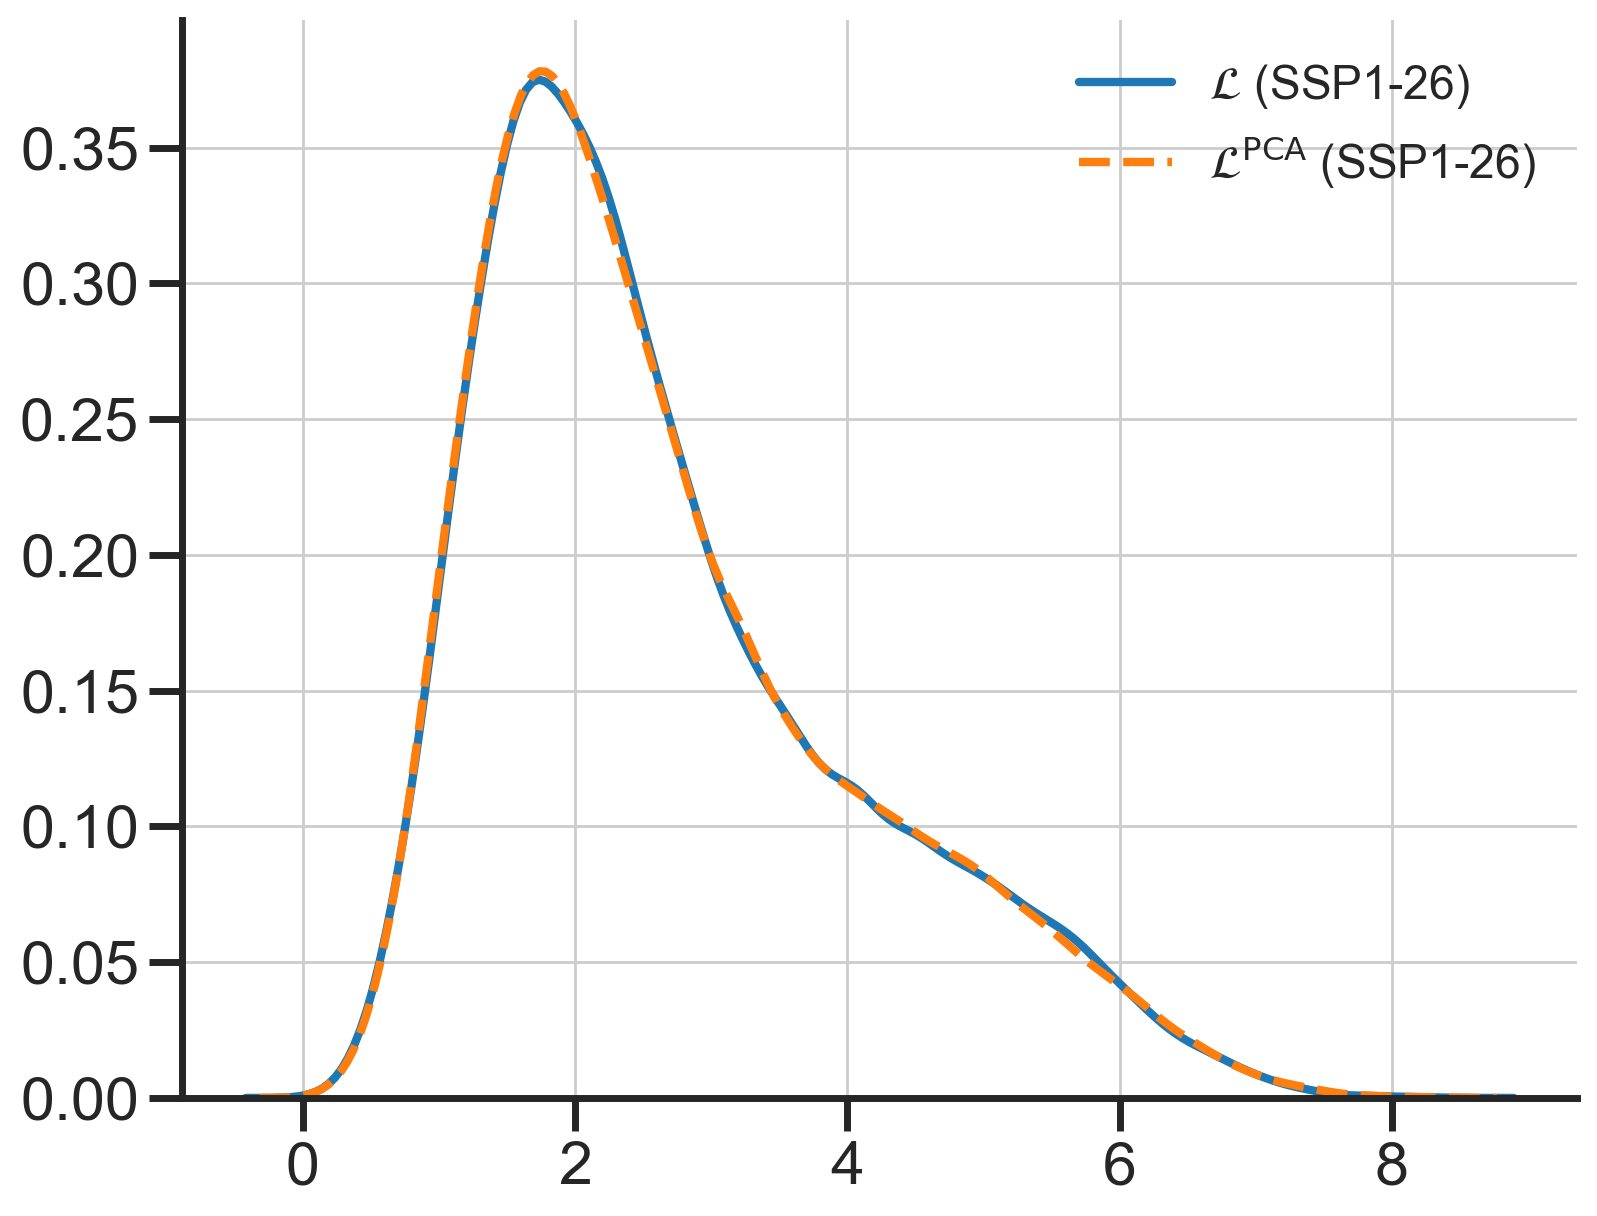

In [24]:
fig, ax = plt.subplots()
for name in sub_scenarios:
    sns.kdeplot(
        data=loss_dict[name],
        linestyle="-",
        label=f"$\\mathcal{{L}}$ ({name})",
        ax=ax,
    )
for name in sub_scenarios:
    sns.kdeplot(
        data=loss_pca[name],
        linestyle="--",
        label=f"$\\mathcal{{L}}^{{\\mathrm{{PCA}}}}$ ({name})",
        ax=ax,
    )
ax.legend(framealpha=0.0, loc="best")
ax.set_ylabel("")
plt.show()

In [25]:
# Pick one scenario
NAME = sub_scenarios[0]

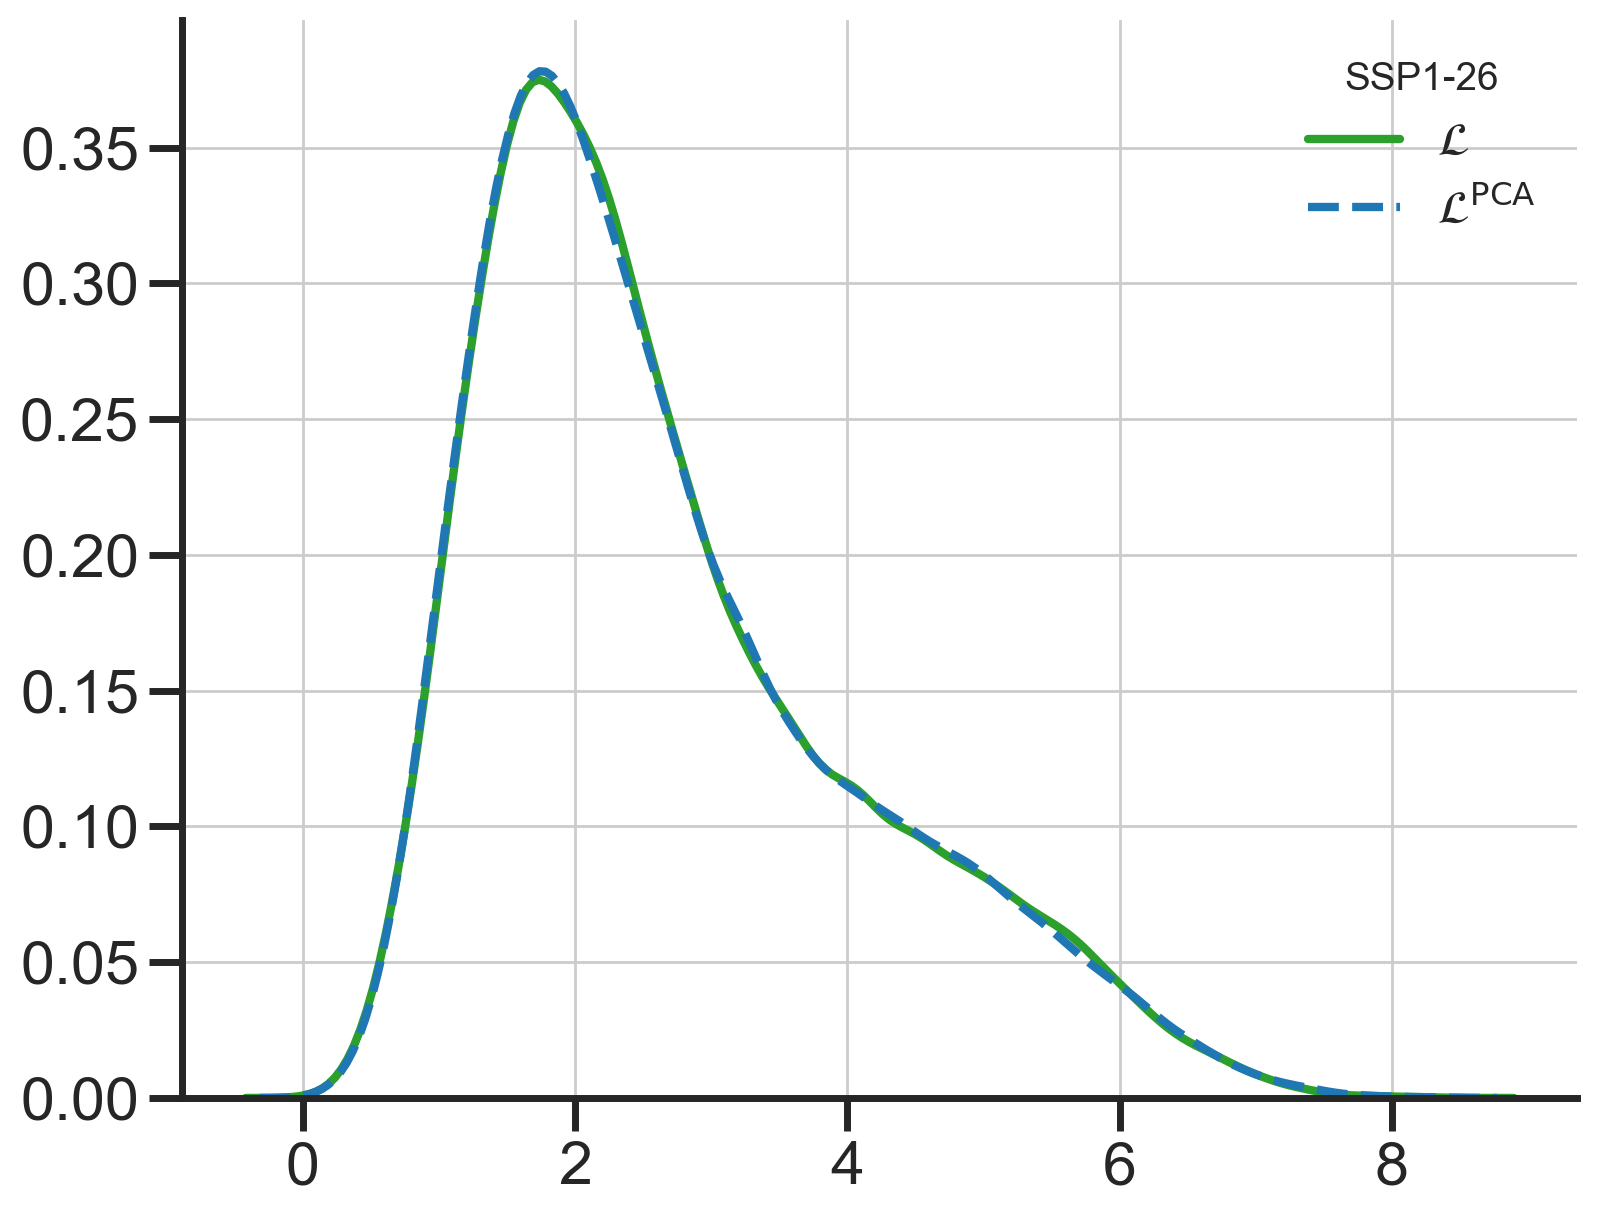

In [26]:
# Plot loss and loss-PCA for one specific scenario
fig, ax = plt.subplots()
sns.kdeplot(
    data=loss_dict[NAME],
    linestyle="-",
    color=COLORS_SSP[NAME],
    label="$\\mathcal{{L}}$",
    ax=ax,
)
sns.kdeplot(
    data=loss_pca[NAME],
    linestyle="--",
    label="$\\mathcal{{L}}^{{\\mathrm{{PCA}}}}$",
    ax=ax,
)
ax.legend(title=f"{NAME}", framealpha=0.0, loc="best")
ax.set_ylabel("")
plt.show()

Q-Q plot


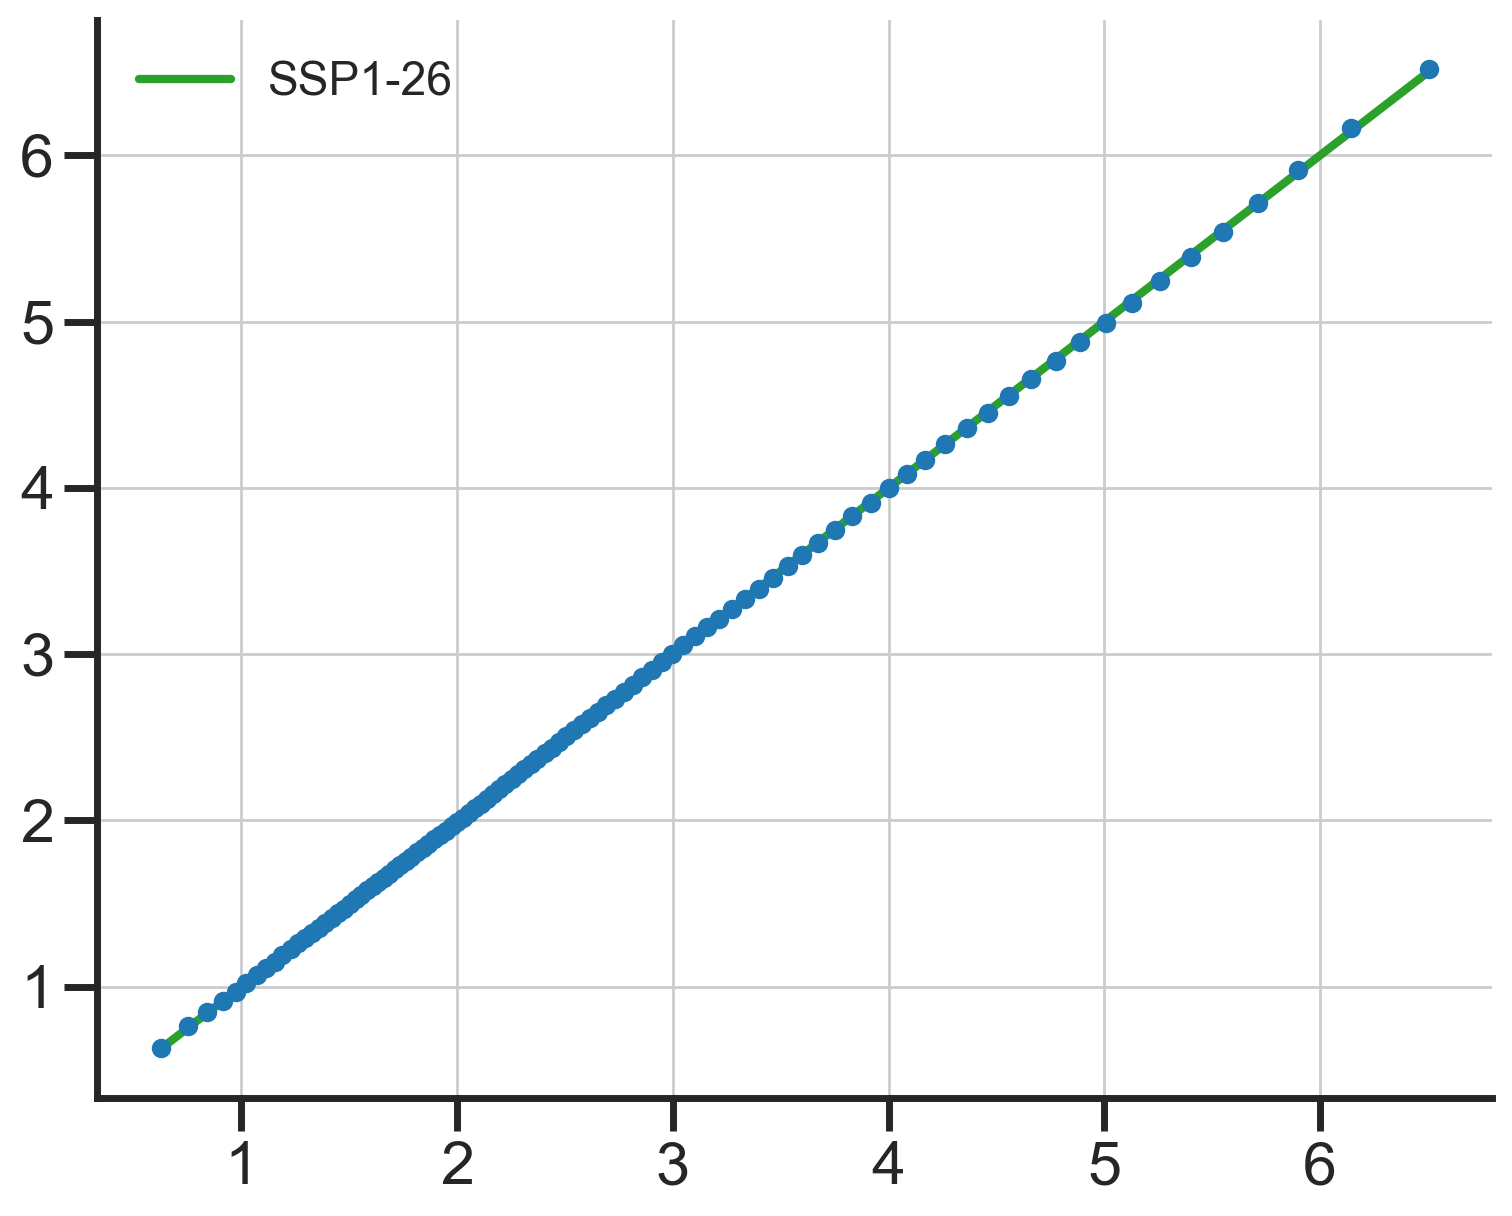

In [27]:
# Plot Q-Q plot for loss and loss-PCA for one specific scenario
fig, ax = plt.subplots()
tab_q = np.linspace(0.01, 0.99, 101)
quantile_loss_pca = np.quantile(loss_pca[NAME], q=tab_q)
quantile_loss = np.quantile(loss_dict[NAME], q=tab_q)
ax.plot(
    quantile_loss,
    quantile_loss,
    "-",
    color=COLORS_SSP[NAME],
    label=f"{NAME}",
)
ax.plot(quantile_loss, quantile_loss_pca, ".")
# ax.set_xlabel(r"$\mathcal{{L}}$ quantiles")
# ax.set_ylabel(r"$\mathcal{L}^{\mathrm{PCA}}$ quantiles")
ax.legend(framealpha=0)
plt.show()

# Physical Risk Impact on Portfolio Loss


We would like to assess how physical risk is impacting the portfolio loss $\mathcal{L}_t$.

We assume that the total losses of the company is a certain percentage of the initial firm's value $V_0^i$:

$$ \sum_{cw, l} \mathbb{E} \left[Z_{t_{ref}}^{i, cw, l}\right] \, \lambda_{t_{ref}}^{cw, l} $$

We take $t_{ref}=0$


In [28]:
def damage_func(temp_atm):
    """
    Damage function as a function of atmospheric temperature
    "temp_atm".
    """
    a1 = 0.0
    a2 = 0.0028388
    return a1 * temp_atm + a2 * temp_atm**2

In [29]:
df = pd.read_csv("data/owid-ipcc-scenarios.csv")
df1 = df[["Scenario", "Year", "Temperature"]]

# SSP names used in "our-world-in-date" are slightly different than those
# from CMIP6
SCENARIOS_OWD = (
    "SSP1 - 2.6",
    "SSP2 - 4.5",
    "SSP3 - Baseline",
    "SSP4 - 6.0",
    "SSP5 - Baseline",
)
df_temp = df1[df1["Scenario"].isin(SCENARIOS_OWD)].reset_index(drop=True)
dict_names = {}
for name_owd, name in zip(SCENARIOS_OWD, SCENARIOS):
    dict_names[name_owd] = name
df_temp["Scenario"] = df_temp["Scenario"].replace(dict_names)

In [30]:
temperature_dict = {}
for name in SCENARIOS:
    _df = df_temp[df_temp["Scenario"] == name]
    # time starts at 2010
    _time = _df["Year"].astype(float).values[1:] - T_SSP_INITIAL
    _temperature = _df["Temperature"].astype(float).values[1:]
    temperature_dict[name] = interpolate.PchipInterpolator(
        x=_time,
        y=_temperature,
    )

We store initial values of the different firms


In [31]:
p0 = np.log(PROD_0)

V_initial_dict = {}
for name in sub_scenarios:
    V_initial_dict[name] = np.array(
        [firm.h(t=0.0, x=p0) for firm in firms_dict[name]]
    ).flatten()

In [32]:
FACTOR = 1e-5
EPD_dict = {}
for name in sub_scenarios:
    integral_damage_temp = integrate.quad(
        func=lambda u, name=name: np.exp(-INT_RATE * (u - T))
        * damage_func(temperature_dict[name](u)),
        a=T,
        b=T_FINAL,
    )[0]

    integral_damage_temp /= damage_func(temperature_dict[name](0.0))

    EPD_dict[name] = FACTOR * V_initial_dict[name] * integral_damage_temp

We now compare the portfolio loss with and without EPD (physical risk term)


In [33]:
np.random.seed(SEED)

loss_dict_physical_risk = {}
loss_dict_new = {}

for name in sub_scenarios:
    # simulation of log production at maturity p_T
    z = np.random.randn(N_FIRMS, N_MC)
    p_T = mean_dict[name][:, None] + L_chol_p @ z

    h_T = np.array(
        [
            firms_dict[name][i].h(
                t=T,
                x=p_T[i, :],
            )
            for i in range(N_FIRMS)
        ]
    )
    L_T = default_boundary_dict[name]
    EPD_T = EPD_dict[name]

    loss_dict_new[name] = np.sum(
        tab_lambda[:, None] * 1.0 * (h_T <= L_T[:, None]),
        axis=0,
    )

    loss_dict_physical_risk[name] = np.sum(
        tab_lambda[:, None] * 1.0 * (h_T <= (L_T + EPD_T)[:, None]),
        axis=0,
    )

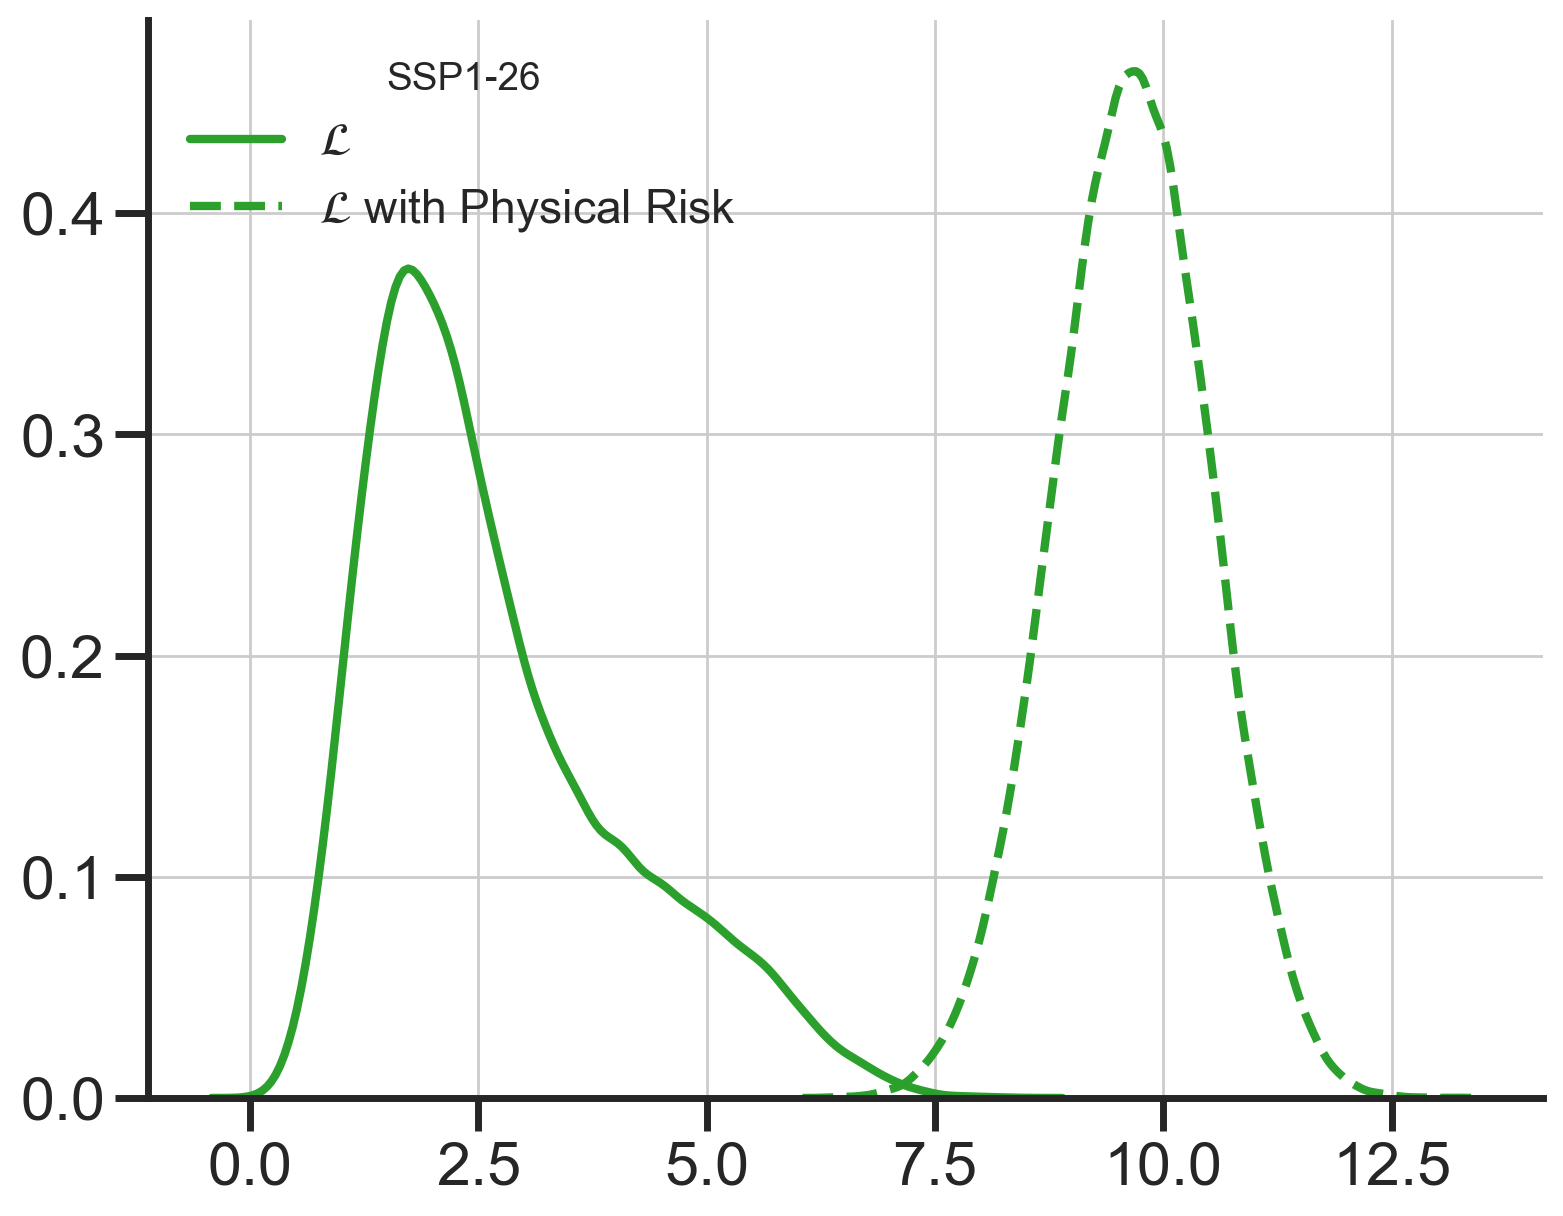

In [34]:
# Plot loss with and without physical risk term for a specific SSP
NAME = SCENARIOS[0]
fig, ax = plt.subplots()
sns.kdeplot(
    data=loss_dict_new[NAME],
    linestyle="-",
    color=COLORS_SSP[NAME],
    label="$\\mathcal{{L}}$",
    ax=ax,
)
# sns.kdeplot(
#     data=loss_dict[NAME],
#     linestyle="--",
#     color="k",
#     label=f"$\\mathcal{{L}}$ ({NAME})",
#     ax=ax,
# )
sns.kdeplot(
    data=loss_dict_physical_risk[NAME],
    linestyle="--",
    color=COLORS_SSP[NAME],
    label="$\\mathcal{{L}}$ with Physical Risk",
    ax=ax,
)
ax.legend(title=f"{NAME}", framealpha=0.0, loc="best")
ax.set_ylabel("")
plt.show()

# Polynomial Chaos Expansion


The final PCA/PCE approximation for the portfolio loss is

$$ \mathcal{L}^{\textrm{PCA,PCE,G}}_{t} := \sum_{m=0}^{M} \sum_{\substack{m_{1},m_{2}\geq 0 \ m_{1}+m_{2}=m}} \varepsilon_{n,m_{1},m_{2}}^{\mathrm{G}} \, \mathrm{He}_{m_{1}}(G^{1}) \, \mathrm{He}_{m_{2}} (G^{2}). $$


In [35]:
# Pick a specific scenario
NAME = sub_scenarios[0]
print(NAME)

SSP1-26


In [36]:
# Pre-compute some values
l1 = np.sqrt(eigs_cov_X[0]) * U_cov_X[:, 0]
l2 = np.sqrt(eigs_cov_X[1]) * U_cov_X[:, 1]
l_norm = np.sqrt(l1**2 + l2**2)
l1_normalized = l1 / l_norm
l2_normalized = l2 / l_norm

std_a_normalized = std_a[NAME] / l_norm
mean_a_normalized = mean_a[NAME] / l_norm

In [37]:
# Checking formulas for the mean vector and covariance matrix of the PCE
M = 4

# mean/cov estimation via recursive relations
mean_a_pce = utils.mean_gauss_pce(
    n=M,
    a=std_a_normalized,
    b=mean_a_normalized,
)
_cov_a_pce = utils.cov_gauss_pce(
    n=2 * M,
    a=std_a_normalized,
    b=mean_a_normalized,
)
cov_a_pce = _cov_a_pce[: M + 1, : M + 1, :]

In [38]:
# mean/cov estimation by quadrature
mean_a_pce_quad, cov_a_pce_quad = utils.mean_cov_pce_quad(
    a=std_a_normalized, b=mean_a_normalized, n_pce=M, n_quad=40
)

In [39]:
cov_pce_quad = (
    cov_a_pce_quad
    + np.transpose(cov_a_pce_quad.copy(), axes=(1, 0, 2))
    - np.diagonal(cov_a_pce_quad).T * np.eye(M + 1)[:, :, None]
)

In [40]:
# mean/cov estimation by MC
# WARNING: if N_FIRMS is large, this might take a lot of time.

g_ind = np.random.randn(N_FIRMS, N_MC)
vec_a = mean_a_normalized[:, None] + std_a_normalized[:, None] * g_ind
tau_vec_a_m = np.array(
    [
        utils.coef_gauss_pce(
            n=int(m),
            x=vec_a,
        )
        for m in np.arange(M + 1)
    ]
)
mean_a_pce_mc = np.mean(tau_vec_a_m, axis=2)
cov_a_pce_mc = np.zeros((M + 1, M + 1, N_FIRMS))
for i in range(N_FIRMS):
    cov_a_pce_mc[:, :, i] = np.cov(tau_vec_a_m[:, i, :])

In [41]:
print(
    "Norm between mean_A_pce_quad and mean_A_pce_mc:",
    np.linalg.norm(mean_a_pce_quad - mean_a_pce_mc).round(3),
)
print(
    "Norm between cov_A_pce_quad and cov_A_pce_mc:",
    np.linalg.norm(cov_a_pce_quad - cov_a_pce_mc).round(3),
)

print(
    "Norm between mean_A_pce and mean_A_pce_mc:",
    np.linalg.norm(mean_a_pce - mean_a_pce_mc).round(3),
)
print(
    "Norm between cov_A_pce and cov_A_pce_mc:",
    np.linalg.norm(cov_a_pce - cov_a_pce_mc).round(3),
)

Norm between mean_A_pce_quad and mean_A_pce_mc: 0.008
Norm between cov_A_pce_quad and cov_A_pce_mc: 0.282
Norm between mean_A_pce and mean_A_pce_mc: 0.008
Norm between cov_A_pce and cov_A_pce_mc: 0.004


In [42]:
# It is more stable to compute the mean and cov parameters
# via a Gauss-Hermite quadrature. We use the function `mean_cov_pce_quad`.

In [43]:
# # Plot eigenvalues of the covariance matrix for the vector eps
# mean_eps, cov_eps = compute_loss_pca_pce(M=5, return_mean_cov_eps=True)
# vec_eps_full = compute_loss_pca_pce(M=5, return_eps_full=True)
# mean_eps_mc = vec_eps_full.mean()
# error = 100 * (mean_eps_mc - mean_eps) / mean_eps_mc
# print(error)
# cov_eps_mc = np.cov(vec_eps_full)
# 100 * (cov_eps_mc - cov_eps) / cov_eps_mc
# U, S, _ = np.linalg.svd(cov_eps)
# plt.plot(S, "b.");

In [44]:
list_n_pce = [1, 3, 5, 10]

loss_pca_pce = {
    n: utils.compute_loss_pca_pce(
        n_pce=n,
        n_firms=N_FIRMS,
        n_mc=N_MC,
        l1_normalized=l1_normalized,
        l2_normalized=l2_normalized,
        std_a_normalized=std_a_normalized,
        mean_a_normalized=mean_a_normalized,
        tab_lambda=tab_lambda,
    )
    for n in list_n_pce
}

Cholesky from SVD
Cholesky from SVD
Cholesky from SVD
Cholesky from SVD


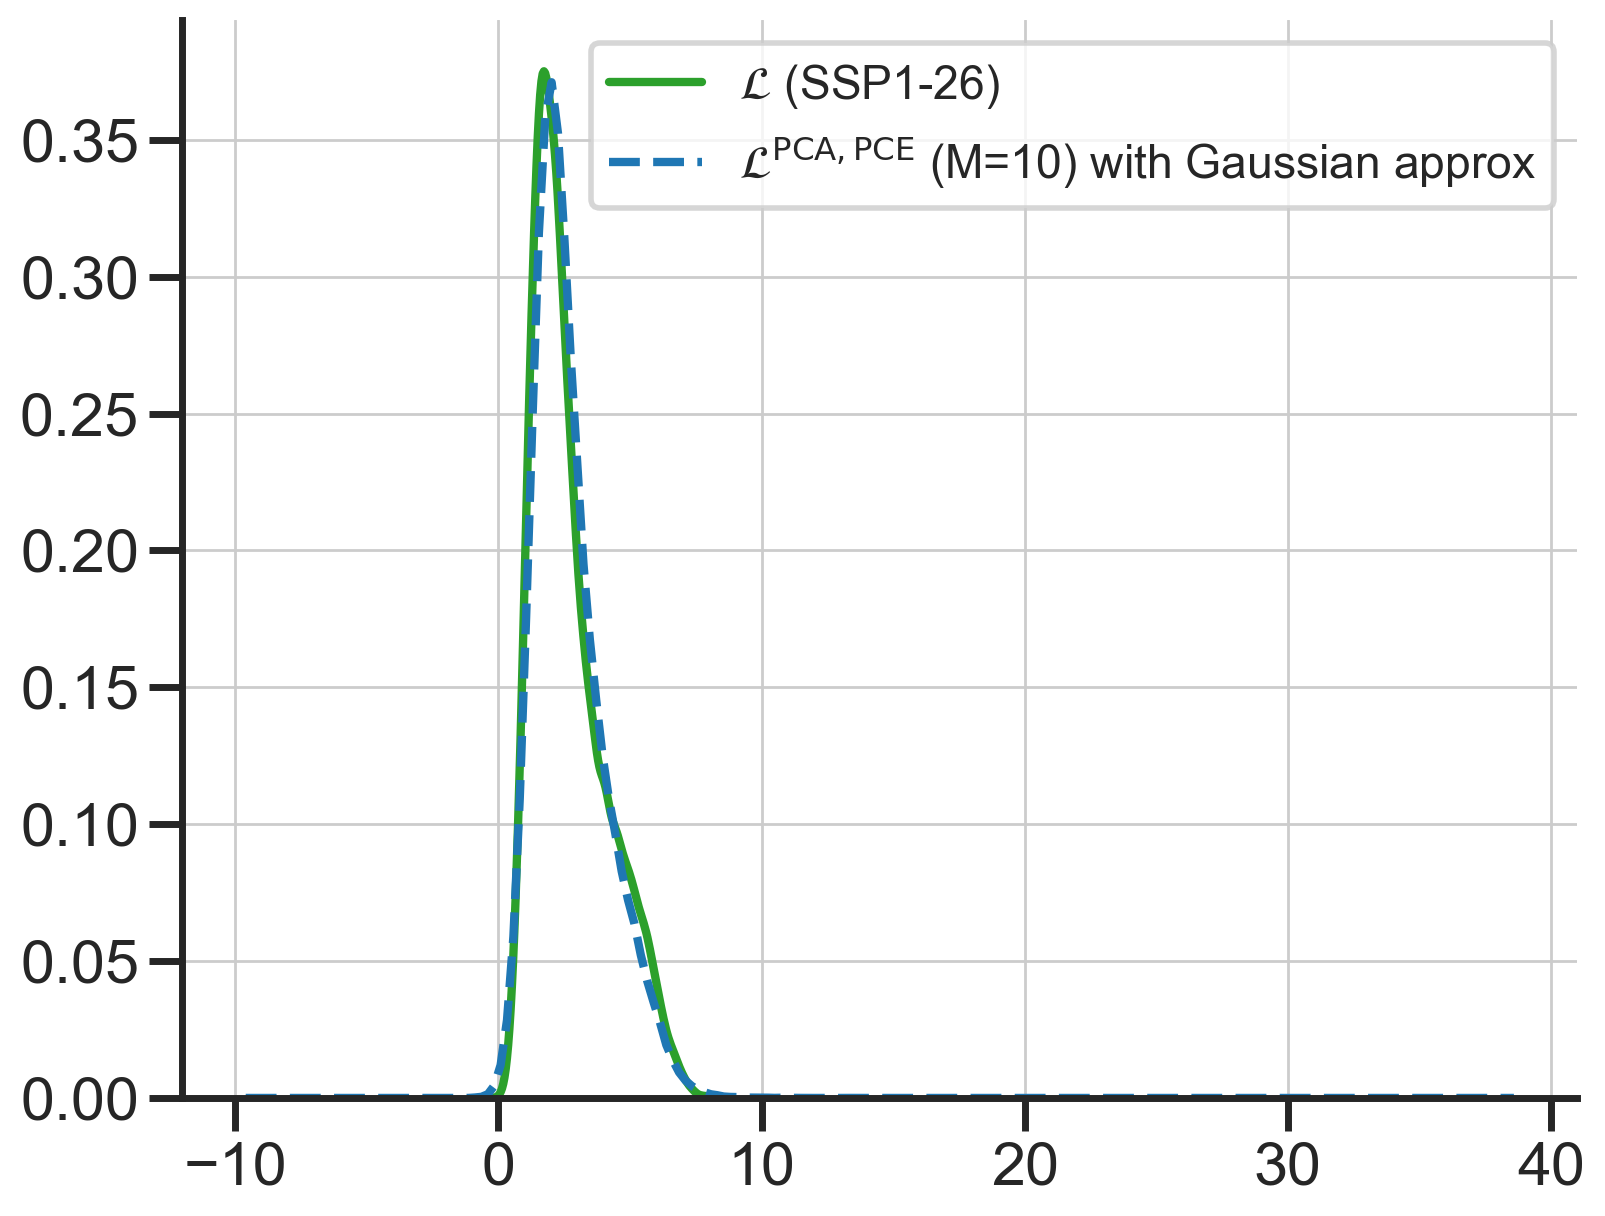

In [45]:
NAME = sub_scenarios[0]
M_PLOT = 10
fig, ax = plt.subplots()
sns.kdeplot(
    loss_dict[NAME],
    linestyle="-",
    color=COLORS_SSP[NAME],
    label=f"$\\mathcal{{L}}$ ({NAME})",
)
LOSS_STR = "$\\mathcal{{L}}^{{\\mathrm{{PCA,PCE}}}}$"
sns.kdeplot(
    loss_pca_pce[M_PLOT],
    linestyle="--",
    label=f"{LOSS_STR} (M={M_PLOT}) with Gaussian approx",
)
# sns.kdeplot(
#     loss_pca_pce_full,
#     linestyle=":",
#     label=f"$\\mathcal{{L}}^{{\\mathrm{{PCA,PCE}}}}$ (M={M_PLOT})",
# )
ax.legend()
ax.set_ylabel("")
plt.show()

Comparison for different truncation parameters $M$


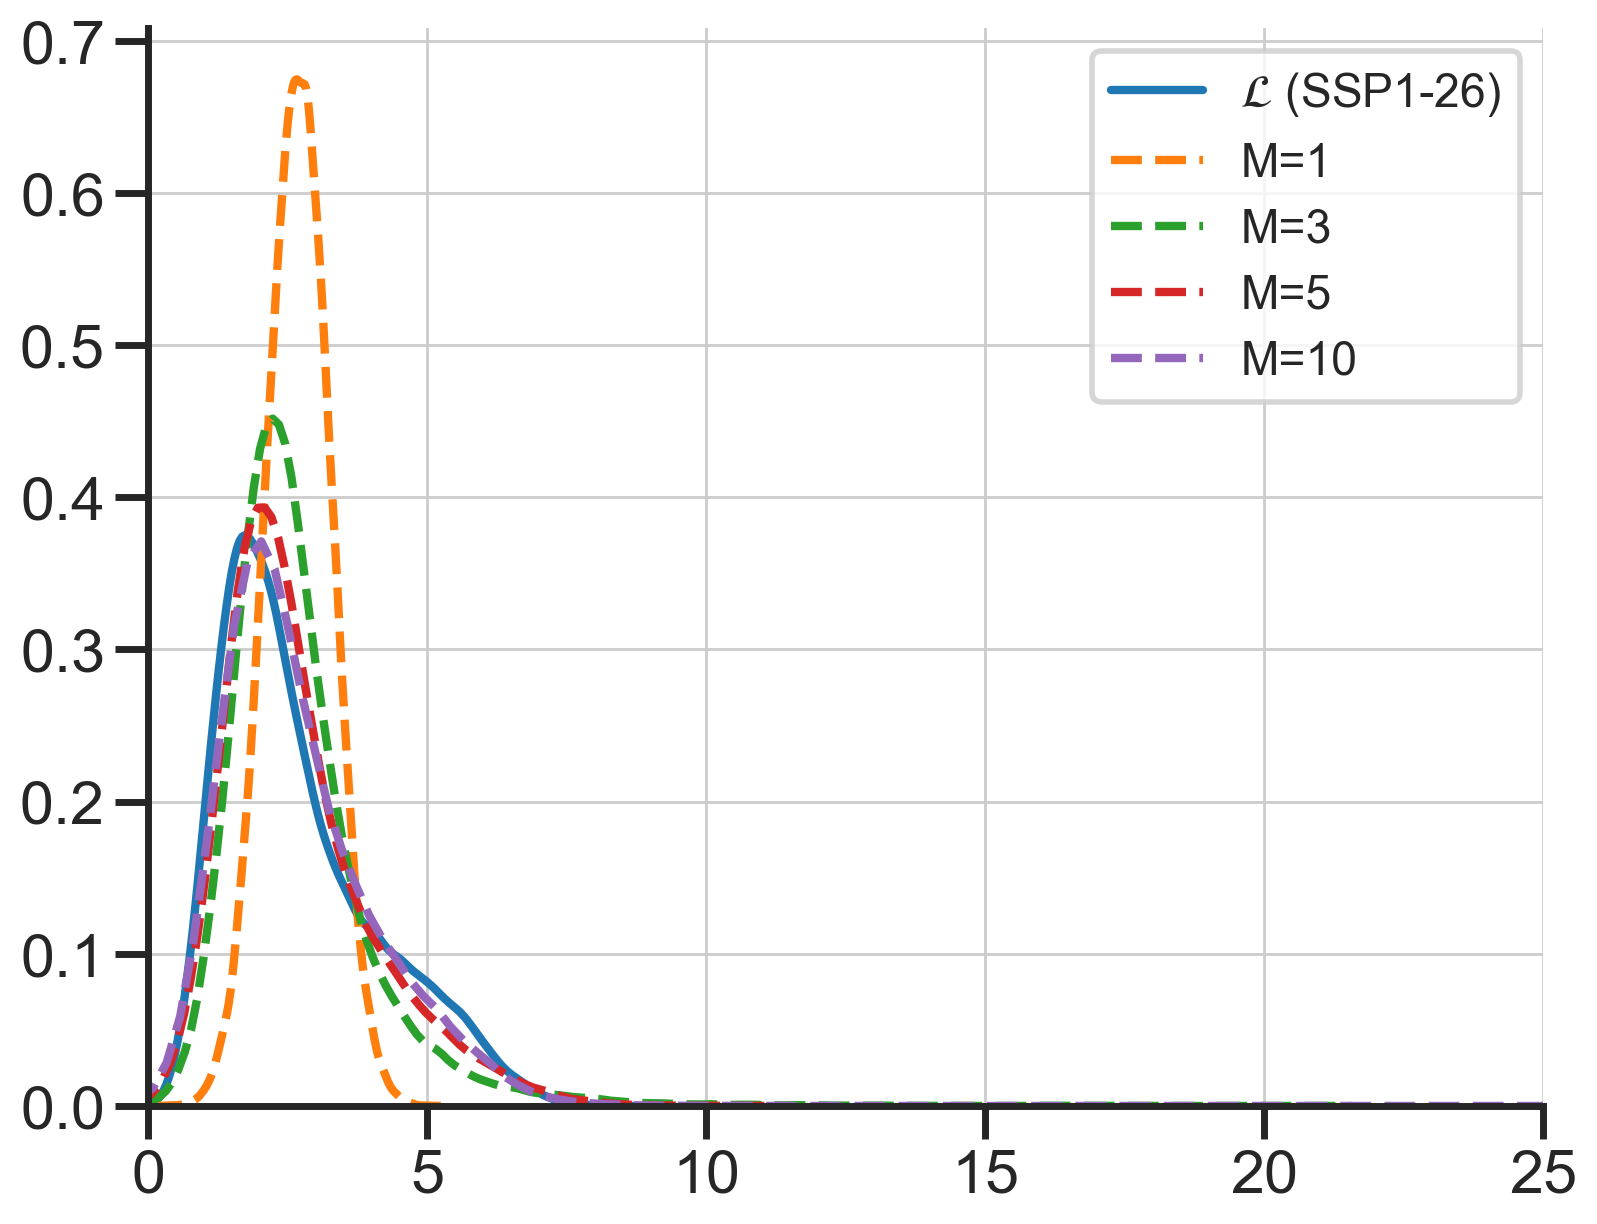

In [46]:
fig, ax = plt.subplots()
sns.kdeplot(
    loss_dict[NAME],
    linestyle="-",
    # color=dict_colors_ssp[NAME],
    label=f"$\\mathcal{{L}}$ ({NAME})",
)

for i, n in enumerate(list_n_pce):
    sns.kdeplot(loss_pca_pce[n], linestyle="--", label=f"M={n}")
ax.legend(loc="best")
ax.set_ylabel("")
ax.set_xlim(0, 25)
plt.show()

Q-Q plot


In [47]:
tab_q = np.linspace(0.01, 0.99, 101)
quantile_loss = np.quantile(loss_dict[NAME], q=tab_q)

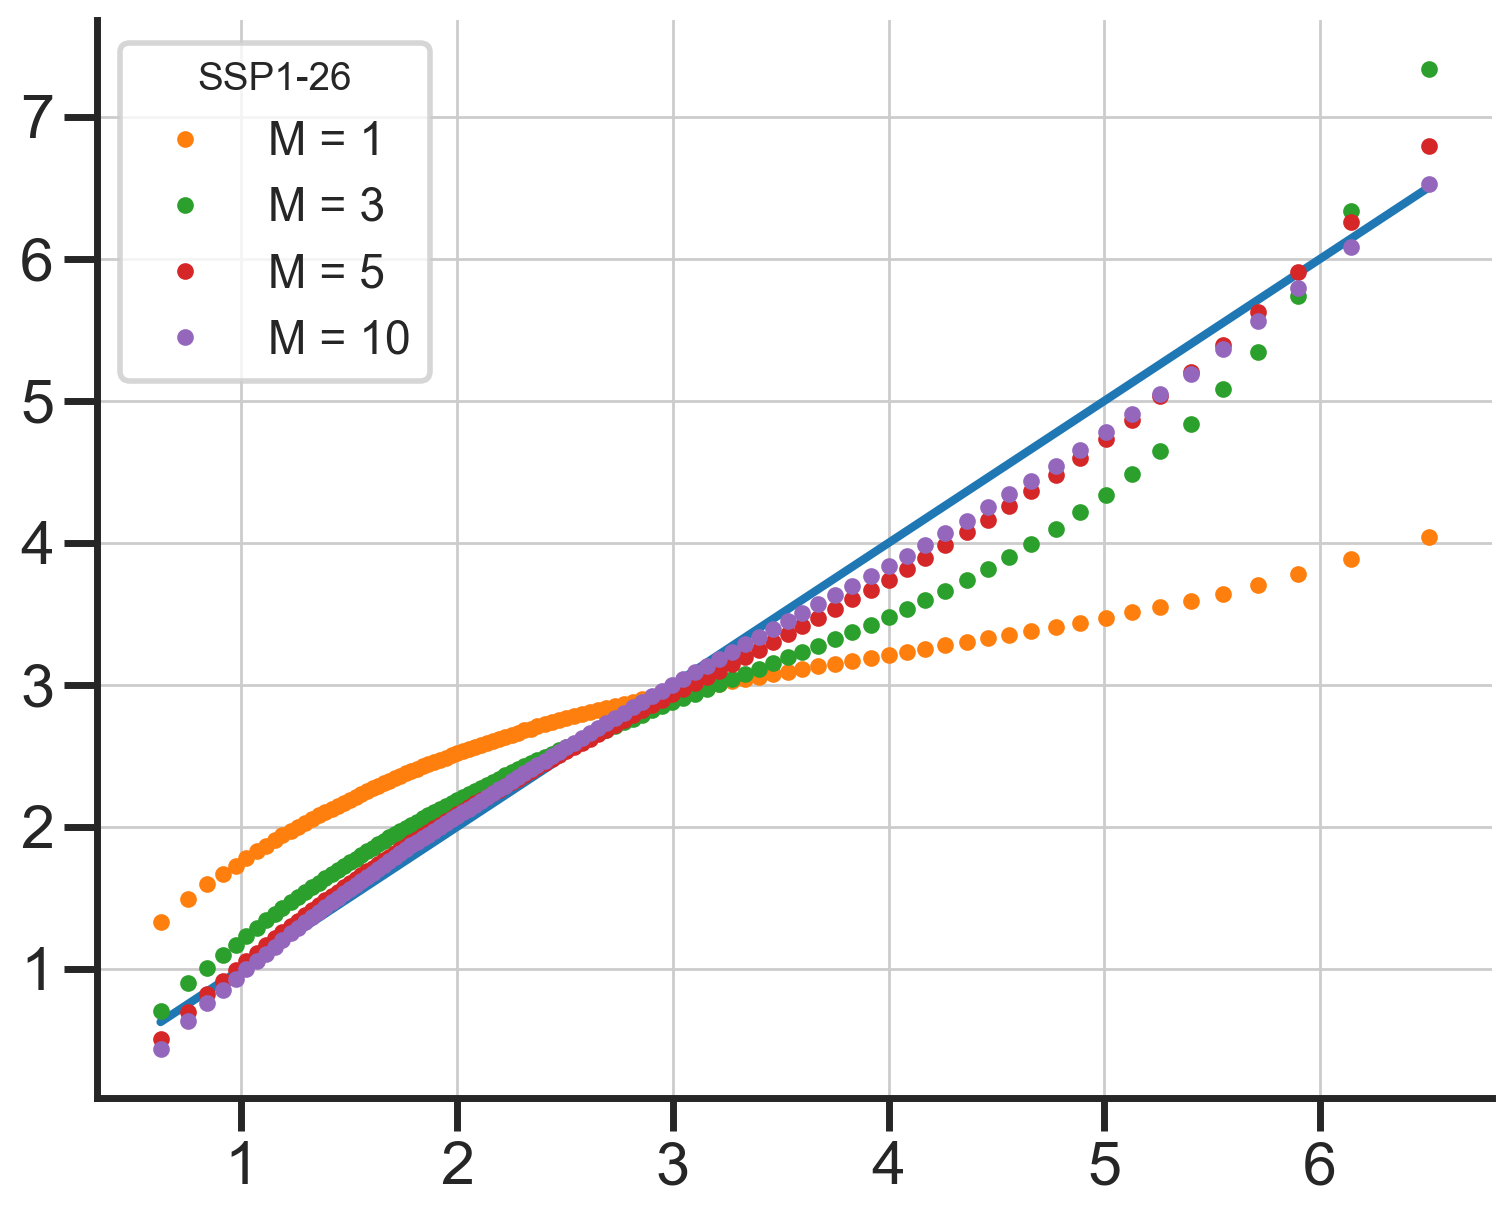

In [48]:
fig, ax = plt.subplots()
ax.plot(quantile_loss, quantile_loss, "-")

for i, n in enumerate(list_n_pce):
    ax.plot(
        quantile_loss,
        np.quantile(loss_pca_pce[n], q=tab_q),
        ".",
        markersize=10,
        label=f"M = {n}",
    )
# ax.set_xlabel("$\\mathcal{{L}}$ quantiles")
# ax.set_ylabel("$\\mathcal{L}^{\\mathrm{PCA,PCE}}$ quantiles")
ax.legend(title=f"{NAME}")
plt.show()